In [1]:
from ast import literal_eval
from csv import reader
from os import listdir, makedirs, path
from pickle import dump
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from model import Seq2Seq, RecurrentAutoencoder, DNNAE, SalTransformer, SalAE, SalSCINet, SalGATSCINet, SalGATSCINetV2, SalGATConvLSTM, SalGATConvGRU, ConvGRU, SalGATConvGRUwoSal, SalConvGRUwoALL


import os, random
import torch
from torch.nn import TransformerAE
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
# from args import get_parser


def load_and_save(category, filename, dataset, dataset_folder, output_folder):
    temp = np.genfromtxt(
        path.join(dataset_folder, category, filename),
        dtype=np.float32,
        delimiter=",",
    )
    print(dataset, category, filename, temp.shape)
    with open(path.join(output_folder, dataset + "_" + category + ".pkl"), "wb") as file:
        dump(temp, file)


def load_data(dataset):
    """ Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly) """

    if dataset == "SMD":
        dataset_folder = "/home/sangyup/saliency_anomaly_detection/dataset/ServerMachineDataset"
        output_folder = "/home/sangyup/saliency_anomaly_detection/dataset/ServerMachineDataset/processed"
        makedirs(output_folder, exist_ok=True)
        file_list = listdir(path.join(dataset_folder, "train"))
        for filename in file_list:
            if filename.endswith(".txt"):
                load_and_save(
                    "train",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )
                load_and_save(
                    "test_label",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )
                load_and_save(
                    "test",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )

    elif dataset == "SMAP" or dataset == "MSL":
        dataset_folder = "/home/sangyup/saliency_anomaly_detection/dataset/SMAPMSL/data"
        output_folder = "/home/sangyup/saliency_anomaly_detection/dataset/SMAPMSL/data/processed"
        makedirs(output_folder, exist_ok=True)
        with open(path.join(dataset_folder, "labeled_anomalies.csv"), "r") as file:
            csv_reader = reader(file, delimiter=",")
            res = [row for row in csv_reader][1:]
        res = sorted(res, key=lambda k: k[0])
        data_info = [row for row in res if row[1] == dataset and row[0] != "P-2"]
        labels = []
        for row in data_info:
            anomalies = literal_eval(row[2])
            length = int(row[-1])
            label = np.zeros([length], dtype=np.bool_)
            for anomaly in anomalies:
                label[anomaly[0] : anomaly[1] + 1] = True
            labels.extend(label)

        labels = np.asarray(labels)
        print(dataset, "test_label", labels.shape)

        with open(path.join(output_folder, dataset + "_" + "test_label" + ".pkl"), "wb") as file:
            dump(labels, file)

        def concatenate_and_save(category):
            data = []
            for row in data_info:
                filename = row[0]
                temp = np.load(path.join(dataset_folder, category, filename + ".npy"))
                data.extend(temp)
            data = np.asarray(data)
            print(dataset, category, data.shape)
            with open(path.join(output_folder, dataset + "_" + category + ".pkl"), "wb") as file:
                dump(data, file)

        for c in ["train", "test"]:
            concatenate_and_save(c)

def normalize_data(data, scaler=None):
    data = np.asarray(data, dtype=np.float32)
    if np.any(sum(np.isnan(data))):
        data = np.nan_to_num(data)

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data)
    data = scaler.transform(data)
    print("Data normalized")

    return data, scaler

def get_data_dim(dataset):
    """
    :param dataset: Name of dataset
    :return: Number of dimensions in data
    """
    if dataset == "SMAP":
        return 25
    elif dataset == "MSL":
        return 55
    elif str(dataset).startswith("machine"):
        return 38
    else:
        raise ValueError("unknown dataset " + str(dataset))

        
def get_data(dataset, max_train_size=None, max_test_size=None,
             normalize=False, spec_res=False, train_start=0, test_start=0):
    """
    Get data from pkl files

    return shape: (([train_size, x_dim], [train_size] or None), ([test_size, x_dim], [test_size]))
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    prefix = "/home/sangyup/saliency_anomaly_detection/dataset"
    if str(dataset).startswith("machine"):
        prefix += "/ServerMachineDataset/processed"
    elif dataset in ["MSL", "SMAP"]:
        prefix += "/SMAPMSL/data/processed"
    if max_train_size is None:
        train_end = None
    else:
        train_end = train_start + max_train_size
    if max_test_size is None:
        test_end = None
    else:
        test_end = test_start + max_test_size
    print("load data of:", dataset)
    print("train: ", train_start, train_end)
    print("test: ", test_start, test_end)
    x_dim = get_data_dim(dataset)
    f = open(os.path.join(prefix, dataset + "_train.pkl"), "rb")
    train_data = pickle.load(f).reshape((-1, x_dim))[train_start:train_end, :]
    f.close()
    try:
        f = open(os.path.join(prefix, dataset + "_test.pkl"), "rb")
        test_data = pickle.load(f).reshape((-1, x_dim))[test_start:test_end, :]
        f.close()
    except (KeyError, FileNotFoundError):
        test_data = None
    try:
        f = open(os.path.join(prefix, dataset + "_test_label.pkl"), "rb")
        test_label = pickle.load(f).reshape((-1))[test_start:test_end]
        f.close()
    except (KeyError, FileNotFoundError):
        test_label = None

    if normalize:
        train_data, scaler = normalize_data(train_data, scaler=None)
        test_data, _ = normalize_data(test_data, scaler=scaler)

    print("train set shape: ", train_data.shape)
    print("test set shape: ", test_data.shape)
    print("test set label shape: ", None if test_label is None else test_label.shape)
    return (train_data, None), (test_data, test_label)

In [2]:
ds = 'MSL'
load_data(ds.upper())

MSL test_label (73729,)
MSL train (58317, 55)
MSL test (73729, 55)


In [3]:
(x_train, _), (x_test, y_test) = get_data('MSL', normalize=True)

load data of: MSL
train:  0 None
test:  0 None
Data normalized
Data normalized
train set shape:  (58317, 55)
test set shape:  (73729, 55)
test set label shape:  (73729,)


In [4]:
def split_series(series, n_past, n_future):
    '''

    :param series: input time series
    :param n_past: number of past observations
    :param n_future: number of future series
    :return: X, y(label)
    '''
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)

    return X, y

x_test_windowed, _ = split_series(x_test, 100, 1)
np.array(x_test_windowed).shape

(73629, 100, 55)

In [5]:
from torch.utils.data import Dataset, DataLoader
class ReconDataset(Dataset):
    def __init__(self, data, window, target_cols):
        self.data = torch.Tensor(data)
        self.window = window
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index:index+self.window]
        return x, y

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)

    def __getsize__(self):
        return (self.__len__())

class ForecastDataset(Dataset):
    def __init__(self, data, window, target_cols):
        self.data = torch.Tensor(data)
        self.window = window
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+self.window,0:self.target_cols]
        return x, y

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

class ReconForecastDataset(Dataset):
    def __init__(self, data, window, horizon):
        self.data = torch.Tensor(data)
        self.window = window
        self.horizon = horizon
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y_recon = self.data[index:index+self.window]
        y_fore = self.data[index+self.window:index+self.window+self.horizon]
        return x, y_recon, y_fore

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape), (self.__len__(), *self.__getitem__(0)[1].shape), (self.__len__(), *self.__getitem__(0)[2].shape)
    
    def __getsize__(self):
        return (self.__len__())


def create_data_loaders(train_dataset, batch_size, val_split=0.1, shuffle=False, test_dataset=None):
    train_loader, val_loader, test_loader = None, None, None
    if val_split == 0.0:
        print(f"train_size: {len(train_dataset)}")
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

    else:
        dataset_size = len(train_dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(val_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=train_sampler, drop_last=True)
        val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=valid_sampler, drop_last=True)

        print(f"train_size: {len(train_indices)}")
        print(f"validation_size: {len(val_indices)}")

    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        print(f"test_size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader


# From Informer

class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y


class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [6]:
window_size = 100
batch_size = 512
horizon = 10

train_dataset = ReconForecastDataset(x_train, window_size, horizon)
indices = torch.arange(len(train_dataset)-horizon)
train_dataset = torch.utils.data.Subset(train_dataset, indices)
test_dataset = ReconForecastDataset(x_test, window_size, horizon)

train_loader, val_loader, test_loader = create_data_loaders(train_dataset, batch_size, val_split=0.3, shuffle=False, test_dataset=test_dataset)

train_size: 40745
validation_size: 17462
test_size: 73629


In [7]:
from time import time

def train(dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            # guess = model(given,given)  # Transformer
            enc_output, guess = model(x)  # AE
            y = y.cuda()
            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history


def train_DNN(dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]).cuda()
            # guess = model(given,given)  # Transformer
            enc_output, guess = model(x)  # AE
            y = y.reshape(y.shape[0], y.shape[1]*y.shape[2]).cuda()
            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history


def train_transformer(dataloader, model, batch_size, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_transformer = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    for e in epochs:
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_transformer = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            sal, dec_x, out = model(x)
            y = y.cuda()
            loss_AE = loss_fn_AE(y, dec_x)
            loss_transformer = loss_fn_transformer(y, out)
            loss = loss_AE + loss_transformer
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_transformer += loss_transformer.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_transformer)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_transformer}] took', time()-start)
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["loss_AE"] = epoch_loss_AE
            best["loss_TF"] = epoch_loss_transformer
            best["epoch"] = e + 1
    return best, loss_history, loss_history_AE, loss_history_TF


def train_SCI(dataloader, model, batch_size, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_sci = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    for e in epochs:
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_sci = 0
        for i, (x,y_recon,y_fore) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            sal, dec_x, out = model(x)
            
            loss_AE = loss_fn_AE(y_recon, dec_x)
            loss_sci = loss_fn_sci(y_fore, out)
            loss = loss_AE + loss_sci
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_sci += loss_sci.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_sci)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_sci}] took', time()-start)
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["loss_AE"] = epoch_loss_AE
            best["loss_TF"] = epoch_loss_sci
            best["epoch"] = e + 1
    return best, loss_history, loss_history_AE, loss_history_TF
 

def train_model(dataloader, val_loader, model, batch_size, n_epochs, model_name):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_sci = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    val_loss_history, val_loss_history_AE, val_loss_history_TF = [], [], []
    for e in epochs:
        model.train()
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_sci = 0
        for i, (x,y_recon,y_fore) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            sal, dec_x, out = model(x)
            
            loss_AE = loss_fn_AE(y_recon, dec_x)
            loss_sci = loss_fn_sci(y_fore, out)
            loss = loss_AE + loss_sci
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_sci += loss_sci.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_sci)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        # Validation step
        model.eval()
        val_epoch_loss = 0
        val_epoch_loss_AE = 0
        val_epoch_loss_sci = 0
        with torch.no_grad():
            for i, (x,y_recon,y_fore) in enumerate(val_loader):  
                x = x.cuda()
                y_recon = y_recon.cuda()
                y_fore = y_fore.cuda()
                sal, dec_x, out = model(x)

                valloss_AE = loss_fn_AE(y_recon, dec_x)
                valloss_sci = loss_fn_sci(y_fore, out)
                valloss = valloss_AE + valloss_sci
                
                val_epoch_loss += valloss.item()
                val_epoch_loss_AE += valloss_AE.item()
                val_epoch_loss_sci += valloss_sci.item()
                
                val_loss_history.append(val_epoch_loss)
                val_loss_history_AE.append(val_epoch_loss_AE)
                val_loss_history_TF.append(val_epoch_loss_sci)  

        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_sci}] took', time()-start)
        print(f'Validation loss EPOCH: [{e+1}|{len(epochs)}], validation loss: [{val_epoch_loss}], AE loss: [{val_epoch_loss_AE}], TF loss: [{val_epoch_loss_sci}]')
        if val_epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = val_epoch_loss
            best["loss_AE"] = val_epoch_loss_AE
            best["loss_TF"] = val_epoch_loss_sci
            best["epoch"] = e + 1
            with open("result/model_" + model_name + "_best.pt", "wb") as f:
                torch.save(
                    {
                        "state": best["state"],
                        "best_epoch": best["epoch"],
                        "loss_history": val_loss_history,
                        "loss_AE_history": val_loss_history_AE,
                        "loss_TF_history": val_loss_history_TF,
                    },
                    f,
                )

    # Save last epoch
    with open("result/model_" + model_name + "_last.pt", "wb") as f:
        torch.save(
            {
                "state": model.state_dict(),
                "best_epoch": e + 1,
                "loss_history": val_loss_history,
                "loss_AE_history": val_loss_history_AE,
                "loss_TF_history": val_loss_history_TF,
            },
            f,
        )

    return best, loss_history, loss_history_AE, loss_history_TF
 

In [8]:
model_name = 'SalGATConvGRUwoAll_saliency_MSL'
with open("result/model_" + model_name + "_best.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

print(SAVED_MODEL['best_epoch'])

# MODEL = SalGATSCINet(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATSCINetV2(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvLSTM(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRU(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRUwoSal(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
MODEL = SalConvGRUwoALL(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')

MODEL.cuda()    
MODEL.load_state_dict(SAVED_MODEL["state"])


21


<All keys matched successfully>

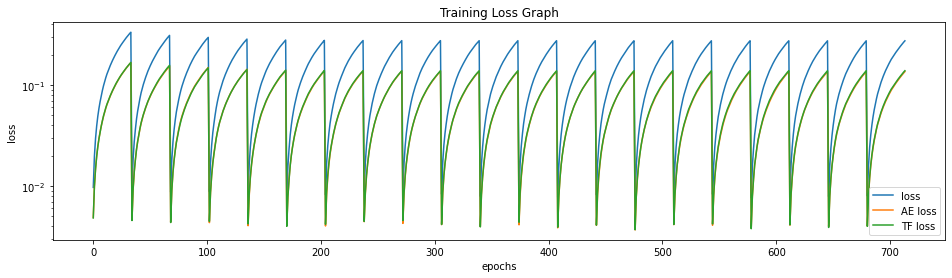

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"], label='loss')
plt.plot(SAVED_MODEL["loss_AE_history"], label='AE loss')
plt.plot(SAVED_MODEL["loss_TF_history"], label='TF loss')
plt.legend()
plt.show()

In [10]:
def inference(dataloader, model, batch_size, TF_alpha):
    dist, dist_sal, fin_dist, guess, sal_list = [], [], [], [], []
    mse = torch.nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            
            sal, dec_x, out = model(x)
            
            for y_s, d, o in zip(y, dec_x, out):
                dist_sal.append(torch.sum(torch.abs(y_s - d)).cpu().numpy())
                # dist_sal.append(mse(y_s,d).item())
                # dist_sal.append(torch.cdist(y_s, d, p=2.0).cpu().numpy())  
                
                dist.append(torch.sum(torch.abs(y_s - o)).cpu().numpy())
                # dist.append(mse(y_s, o).item())
                # dist.append(torch.cdist(y_s, o, p=2.0).cpu().numpy())  

                fin_dist.append((1-TF_alpha)*torch.sum(torch.abs(y_s - d)).cpu().numpy() + TF_alpha*torch.sum(torch.abs(y_s - o)).cpu().numpy())
                # fin_dist.append((1-TF_alpha)*mse(y_s,d).item() + TF_alpha*mse(y_s, o).item())
                # fin_dist.append((TF_alpha*torch.cdist(y_s, o, p=2.0) + (1-TF_alpha)*torch.cdist(y_s, d, p=2.0)).cpu().numpy())

            guess.append(out.cpu().numpy())
            sal_list.append(sal.cpu().numpy())
        
            
    return (
        dist,
        dist_sal,
        fin_dist,
        np.concatenate(guess),
        np.concatenate(sal_list)
    )


def inference_SAL(dataloader, model, batch_size, TF_alpha):
    dist, dist_sal, fin_dist1, fin_dist2, guess, sal_list = [], [], [], [], [], []
    mse = torch.nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i, (x,y_recon,y_fore) in enumerate(dataloader):
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            
            sal, dec_x, out = model(x)
            
            for y_r, y_f, d, o in zip(y_recon, y_fore, dec_x, out):
                d_s = torch.sum(torch.square(y_r - d)).cpu().numpy()
                d_o = torch.sum(torch.square(y_f - o)).cpu().numpy()
                # d_s = torch.mean(torch.square(y_r - d)).cpu().numpy()
                # d_o = torch.mean(torch.square(y_f - o)).cpu().numpy()
                
                dist_sal.append(d_s)
                dist.append(d_o)

                # inference_score1 = (d_s + d_o)/(1+TF_alpha)
                inference_score1 = ((1-TF_alpha)*d_s + TF_alpha*d_o)/(1+TF_alpha)
                inference_score2 = (d_s + TF_alpha*d_o)/(1+TF_alpha)
                fin_dist1.append(inference_score1)
                fin_dist2.append(inference_score2)
                # fin_dist.append((1-TF_alpha)*mse(y_s,d).item() + TF_alpha*mse(y_s, o).item())
                # fin_dist.append((TF_alpha*torch.cdist(y_s, o, p=2.0) + (1-TF_alpha)*torch.cdist(y_s, d, p=2.0)).cpu().numpy())

            guess.append(out.cpu().numpy())
            sal_list.append(sal.cpu().numpy())
        
            
    return (
        dist,
        dist_sal,
        fin_dist1,
        fin_dist2,
        np.concatenate(guess),
        np.concatenate(sal_list)
    )


def inference_DNN(dataloader, model, batch_size):
    ts, dist, att, guess_res, enc_list = [], [], [], [], []
    mse = torch.nn.MSELoss()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):  
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]).cuda()
            y = y.reshape(y.shape[0], y.shape[1]*y.shape[2]).cuda()
            enc, guess = model(x)
            
            for y_s, g in zip(y, guess):
                dist.append(torch.sum(torch.abs(y_s - g)).cpu().numpy())  # Normal GRU

            guess_res.append(guess.cpu().numpy())
            enc_list.append(enc.cpu().numpy())
        
            
    return (
        dist,
        np.concatenate(guess_res),
        np.concatenate(enc_list)
    )

### Inference

In [11]:
%%time
from sklearn import metrics

MODEL.eval()
alpha = 1.0
DIST, DIST_SAL, FIN_DIST1, FIN_DIST2, GUESS, SAL_LIST = inference_SAL(test_loader, MODEL, batch_size, TF_alpha=alpha)
DIST_train, DIST_SAL_train, FIN_DIST1_train, FIN_DIST2_train, GUESS_train, SAL_LIST_train = inference_SAL(train_loader, MODEL, batch_size, TF_alpha=alpha)

# anomaly score of test dataset
res = SAL_LIST[:,-1:,:]
res = res.reshape(res.shape[0], res.shape[2])
res_mean = np.mean(res, axis=1)
FD1wSAL = np.array(FIN_DIST1)*res_mean

# anomaly score of train dataset --> to calculate the threshold
res_train = SAL_LIST_train[:,-1:,:]
res_train = res_train.reshape(res_train.shape[0], res_train.shape[2])
res_mean_train = np.mean(res_train, axis=1)
FD1wSAL_train = np.array(FIN_DIST1_train)*res_mean_train


fpr, tpr, thresholds = metrics.roc_curve(y_test[-len(FD1wSAL):].astype(int), FD1wSAL, pos_label=1)
metrics.auc(fpr, tpr)

CPU times: user 15min 1s, sys: 27.2 s, total: 15min 28s
Wall time: 23.2 s


0.6021214114845479

### Anomaly Score

In [79]:
# anomaly score of test dataset
res = SAL_LIST[:,-1:,:]
res = res.reshape(res.shape[0], res.shape[2])
res_mean = np.mean(res, axis=1)
FD1wSAL = np.array(FIN_DIST1)*res_mean

# anomaly score of train dataset --> to calculate the threshold
res_train = SAL_LIST_train[:,-1:,:]
res_train = res_train.reshape(res_train.shape[0], res_train.shape[2])
res_mean_train = np.mean(res_train, axis=1)
FD1wSAL_train = np.array(FIN_DIST1_train)*res_mean_train

### Plot Saliency Map

<AxesSubplot:>

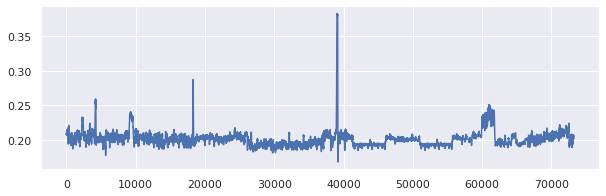

In [13]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,3))
res_plot = SAL_LIST[:,-1:,:]
res_plot = res_plot.reshape(res_plot.shape[0], res_plot.shape[2])
res_plot_mean = np.mean(res_plot, axis=1)
# plt.plot(res_plot_mean) 
# plt.plot(x_test[:,1:2])
# plt.plot(y_test*-1) 


sns.lineplot(data=res_plot_mean, legend=False)
# sns.lineplot(data=x_test, legend=False)


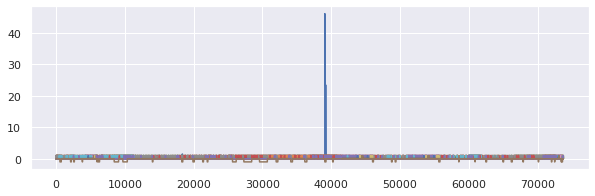

In [14]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(10,3))
total_len = len(x_test)

plt.plot(x_test[:total_len])
plt.plot(y_test[:total_len]*-1)

In [46]:
from spot import SPOT, dSPOT
def adjust_predicts(score, label, threshold, pred=None, calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
            score (np.ndarray): The anomaly score
            label (np.ndarray): The ground-truth label
            threshold (float): The threshold of anomaly score.
                    A point is labeled as "anomaly" if its score is lower than the threshold.
            pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
            calc_latency (bool):
    Returns:
            np.ndarray: predict labels

    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    if label is None:
        predict = score > threshold
        return predict, None

    if pred is None:
        if len(score) != len(label):
            raise ValueError("score and label must have the same length")
        predict = score > threshold
    else:
        predict = pred

    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    latency = 0

    for i in range(len(predict)):
        if any(actual[max(i, 0) : i + 1]) and predict[i] and not anomaly_state:
            anomaly_state = True
            anomaly_count += 1
            for j in range(i, 0, -1):
                if not actual[j]:
                    break
                else:
                    if not predict[j]:
                        predict[j] = True
                        latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
            predict (np.ndarray): the predict label
            actual (np.ndarray): np.ndarray
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN

def pot_eval(init_score, score, label, q=1e-3, level=0.99, dynamic=False):
    """
    Run POT method on given score.
    :param init_score (np.ndarray): The data to get init threshold.
                    For `OmniAnomaly`, it should be the anomaly score of train set.
    :param: score (np.ndarray): The data to run POT method.
                    For `OmniAnomaly`, it should be the anomaly score of test set.
    :param label (np.ndarray): boolean list of true anomalies in score
    :param q (float): Detection level (risk)
    :param level (float): Probability associated with the initial threshold t
    :return dict: pot result dict
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """

    print(f"Running POT with q={q}, level={level}..")
    s = SPOT(q)  # SPOT object
    s.fit(init_score, score)
    s.initialize(level=level, min_extrema=False)  # Calibration step
    ret = s.run(dynamic=dynamic, with_alarm=False)

    print(len(ret["alarms"]))
    print(len(ret["thresholds"]))

    pot_th = np.mean(ret["thresholds"])
    pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True)


    # CHANGE HERE TO CHECK THE THRESHOLD
    plt.figure(figsize=(10,6))
    plt.plot(score)
    plt.plot(label*-50)
    plt.plot(pred*-50, alpha=0.5)
    if dynamic:
        plt.plot(ret["thresholds"])
    else:
        plt.axhline(y=pot_th, color='r', linestyle='-')
    plt.axis([-50, len(score)+50, -100, 100])
    plt.show()


    if label is not None:
        p_t = calc_point2point(pred, label)
        return {
            "f1": p_t[0],
            "precision": p_t[1],
            "recall": p_t[2],
            "TP": p_t[3],
            "TN": p_t[4],
            "FP": p_t[5],
            "FN": p_t[6],
            "threshold": pot_th,
            "latency": p_latency,
        }
    else:
        return {
            "threshold": pot_th,
        }



In [80]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test[-len(FD1wSAL):].astype(int), FD1wSAL, pos_label=1)
print(fpr)
metrics.auc(fpr, tpr)

[0.00000000e+00 1.52788388e-05 3.74331551e-03 ... 9.99923606e-01
 9.99923606e-01 1.00000000e+00]


0.6069360262073598

In [34]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test[-len(FIN_DIST1):].astype(int), FIN_DIST1, pos_label=1)
print(fpr)
metrics.auc(fpr, tpr)

[0.00000000e+00 1.52788388e-05 1.39037433e-03 ... 9.99755539e-01
 9.99755539e-01 1.00000000e+00]


0.6029566540169318

Running POT with q=0.1, level=0.35..
Initial threshold : 2.4156920186690485
Number of peaks : 26291
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 3.435861151824569
	L = 58741.12930006806
Extreme quantile (probability = 0.1): 8.846918265119335


100%|██████████| 73216/73216 [00:00<00:00, 2098986.78it/s]

0
73216


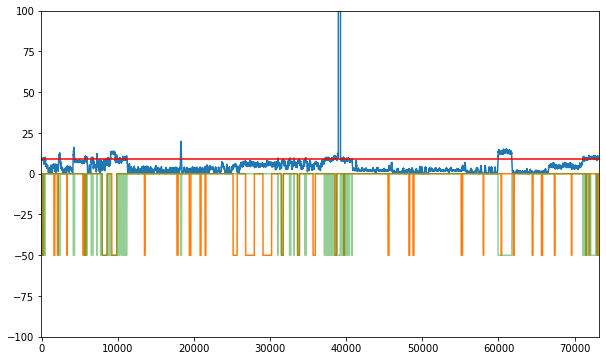

{'f1': 0.3105597730791296,
 'precision': 0.28036510706320394,
 'recall': 0.34805562664427553,
 'TP': 2703,
 'TN': 58512,
 'FP': 6938,
 'FN': 5063,
 'threshold': 8.84691826511934,
 'latency': 79.6916946792717}

In [59]:
pot_th = pot_eval(FD1wSAL_train, FD1wSAL, y_test[-len(FD1wSAL):], q=0.1, level=0.35, dynamic=False)
pot_th

In [23]:
best = 0.0
b_q = 1
b_level = 1
q = 0.001
level = 0.0
for i in range(99):
    level = level + 0.01
    pot_th = pot_eval(FD1wSAL_train, FD1wSAL, y_test[-len(FD1wSAL):], q=q, level=level, dynamic=False)
    if best < pot_th['f1']:
        best = pot_th['f1']
        b_q = q
        b_level = level

print('F1 score: ', pot_th['f1'])
print('q: ', b_q)
print('level: ', b_level)

Running POT with q=0.001, level=0.91..
Initial threshold : 0.5486179983425998
Number of peaks : 3640
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.20705758723562262
	σ = 0.13318247411939813
	L = 4452.057400512555
Extreme quantile (probability = 0.001): 0.9384813755048627


100%|██████████| 73216/73216 [00:00<00:00, 2201820.89it/s]


0
73216
Running POT with q=0.001, level=0.92..
Initial threshold : 0.5641060007071985
Number of peaks : 3235
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.20742986660162188
	σ = 0.13003835333822056
	L = 4035.195731429075
Extreme quantile (probability = 0.001): 0.9383898367511323


100%|██████████| 73216/73216 [00:00<00:00, 2137781.41it/s]

0
73216


Running POT with q=0.001, level=0.93..
Initial threshold : 0.5794960746923863
Number of peaks : 2831
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2256624814530236
	σ = 0.13059087688391113
	L = 3570.877324474748
Extreme quantile (probability = 0.001): 0.9363271145451492


100%|██████████| 73216/73216 [00:00<00:00, 1800555.61it/s]


0
73216
Running POT with q=0.001, level=0.9400000000000001..
Initial threshold : 0.5970911108371553
Number of peaks : 2426
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.24160549027679257
	σ = 0.13051388851516288
	L = 3100.1396038046387
Extreme quantile (probability = 0.001): 0.9363867413875944


100%|██████████| 73216/73216 [00:00<00:00, 2201457.85it/s]


0
73216
Running POT with q=0.001, level=0.9500000000000001..
Initial threshold : 0.6169699790182293
Number of peaks : 2022
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.26744619048850304
	σ = 0.13191731226813885
	L = 2614.498906397768
Extreme quantile (probability = 0.001): 0.936955242530346


100%|██████████| 73216/73216 [00:00<00:00, 2167445.37it/s]


0
73216
Running POT with q=0.001, level=0.9600000000000001..
Initial threshold : 0.6428786018905157
Number of peaks : 1617
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2824694058851749
	σ = 0.12904622300833735
	L = 2150.697361322789
Extreme quantile (probability = 0.001): 0.9385490257511797


100%|██████████| 73216/73216 [00:00<00:00, 2111107.64it/s]


0
73216
Running POT with q=0.001, level=0.9700000000000001..
Initial threshold : 0.6774575833405336
Number of peaks : 1213
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.28918057849879886
	σ = 0.12108075931658834
	L = 1698.7799379074927
Extreme quantile (probability = 0.001): 0.9395587146493747


100%|██████████| 73216/73216 [00:00<00:00, 2149798.82it/s]

0
73216


Running POT with q=0.001, level=0.9800000000000001..
Initial threshold : 0.7228735226065481
Number of peaks : 808
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.29789281049822813
	σ = 0.11011635733314912
	L = 1215.3212749665747
Extreme quantile (probability = 0.001): 0.9410365599100381


100%|██████████| 73216/73216 [00:00<00:00, 2169175.40it/s]

0
73216


Running POT with q=0.001, level=0.9900000000000001..
Initial threshold : 0.7966207259805174
Number of peaks : 404
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.24639959109773868
	σ = 0.07846245687329197
	L = 723.7799848978402
Extreme quantile (probability = 0.001): 0.9344433888936784


100%|██████████| 73216/73216 [00:00<00:00, 2141523.32it/s]

0
73216


F1 score:  0.3450771573567127
q:  0.001
level:  0.9800000000000001


In [21]:
best = 0.0
b_q = 1
b_level = 1
q = 0.001
level = 0.0
for i in range(99):
    level = level + 0.01
    pot_th = pot_eval(FD1wSAL_train, FD1wSAL, y_test[-len(FD1wSAL):], q=q, level=level, dynamic=False)
    if best < pot_th['f1']:
        best = pot_th['f1']
        b_q = q
        b_level = level

print('F1 score: ', pot_th['f1'])
print('q: ', b_q)
print('level: ', b_level)

Running POT with q=0.001, level=0.01..
Initial threshold : 0.0007990510449161492
Number of peaks : 40043
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.018854165107925702
	σ = 0.20715333596937324
	L = 23751.51232025378
Extreme quantile (probability = 0.001): 1.3406660442942202


100%|██████████| 73216/73216 [00:00<00:00, 2131652.77it/s]

0
73216
Running POT with q=0.001, level=0.02..
Initial threshold : 0.0008376726038121923
Number of peaks : 39639
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.03884816172322947
	σ = 0.2133973819634282
	L = 23127.270304408004
Extreme quantile (probability = 0.001): 1.2904135133686605


100%|██████████| 73216/73216 [00:00<00:00, 2136442.87it/s]

0
73216
Running POT with q=0.001, level=0.03..
Initial threshold : 0.000897761224510657
Number of peaks : 39234
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.08177211990876931
	σ = 0.2248695142267167
	L = 22520.594627509556
Extreme quantile (probability = 0.001): 1.1837710738194946


100%|██████████| 73216/73216 [00:00<00:00, 2155033.80it/s]

0
73216
Running POT with q=0.001, level=0.04..
Initial threshold : 0.0009500010021094157
Number of peaks : 38830
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.10564920945404555
	σ = 0.23243367666995032
	L = 21931.1671376156
Extreme quantile (probability = 0.001): 1.1359799561266706


100%|██████████| 73216/73216 [00:00<00:00, 2113883.25it/s]

0
73216
Running POT with q=0.001, level=0.05..
Initial threshold : 0.0010204700487561613
Number of peaks : 38425
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.13118690766350427
	σ = 0.24059469069463355
	L = 21357.70820227371
Extreme quantile (probability = 0.001): 1.0889714025646242


100%|██████████| 73216/73216 [00:00<00:00, 1968779.08it/s]

0
73216
Running POT with q=0.001, level=0.060000000000000005..
Initial threshold : 0.001093556595646139
Number of peaks : 38021
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.15822557041780705
	σ = 0.24936548014137908
	L = 20799.81530551848
Extreme quantile (probability = 0.001): 1.0436053331556905


100%|██████████| 73216/73216 [00:00<00:00, 2148445.19it/s]

0
73216
Running POT with q=0.001, level=0.07..
Initial threshold : 0.001220933048007744
Number of peaks : 37616
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.18303347538477843
	σ = 0.2577905592058075
	L = 20261.53058205209
Extreme quantile (probability = 0.001): 1.006561106347252


100%|██████████| 73216/73216 [00:00<00:00, 2029529.66it/s]

0
73216
Running POT with q=0.001, level=0.08..
Initial threshold : 0.00139238214718327
Number of peaks : 37212
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.20536331994832202
	σ = 0.2657551970281462
	L = 19742.567076815605
Extreme quantile (probability = 0.001): 0.9768215591165523


100%|██████████| 73216/73216 [00:00<00:00, 1905096.73it/s]

0
73216
Running POT with q=0.001, level=0.09..
Initial threshold : 0.0015642177325339707
Number of peaks : 36807
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.2202231424634803
	σ = 0.2718989783883499
	L = 19233.4178728352
Extreme quantile (probability = 0.001): 0.9608588243848923


100%|██████████| 73216/73216 [00:00<00:00, 2154791.86it/s]

0
73216
Running POT with q=0.001, level=0.09999999999999999..
Initial threshold : 0.001741322800827838
Number of peaks : 36403
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.23882427151320962
	σ = 0.27919071044462646
	L = 18736.0581136959
Extreme quantile (probability = 0.001): 0.9404711478689999


100%|██████████| 73216/73216 [00:00<00:00, 2172966.62it/s]

0
73216
Running POT with q=0.001, level=0.10999999999999999..
Initial threshold : 0.0020137849337037994
Number of peaks : 35998
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.2529460575696245
	σ = 0.28528281622852975
	L = 18258.91674388237
Extreme quantile (probability = 0.001): 0.9274530064076485


100%|██████████| 73216/73216 [00:00<00:00, 2148445.19it/s]


0
73216
Running POT with q=0.001, level=0.11999999999999998..
Initial threshold : 0.002413616500870075
Number of peaks : 35594
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2651070535743322
	σ = 0.2907868508027177
	L = 17806.674635769246
Extreme quantile (probability = 0.001): 0.917497273690266


100%|██████████| 73216/73216 [00:00<00:00, 1992591.05it/s]


0
73216
Running POT with q=0.001, level=0.12999999999999998..
Initial threshold : 0.0028089914275429145
Number of peaks : 35189
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2827954925219208
	σ = 0.2980350761955779
	L = 17360.126711850327
Extreme quantile (probability = 0.001): 0.9012752435988659


100%|██████████| 73216/73216 [00:00<00:00, 2125971.20it/s]

0
73216
Running POT with q=0.001, level=0.13999999999999999..
Initial threshold : 0.00324296338945107
Number of peaks : 34785
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.2945576729259878
	σ = 0.3036092702552241
	L = 16925.385189466873
Extreme quantile (probability = 0.001): 0.8931192318542812


100%|██████████| 73216/73216 [00:00<00:00, 1765809.48it/s]

0
73216
Running POT with q=0.001, level=0.15..
Initial threshold : 0.0037912799947995013
Number of peaks : 34380
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.3037320884098015
	σ = 0.308378747394804
	L = 16507.854061955928
Extreme quantile (probability = 0.001): 0.8882203664940391


100%|██████████| 73216/73216 [00:00<00:00, 2194614.14it/s]

0
73216
Running POT with q=0.001, level=0.16..
Initial threshold : 0.004497037418386446
Number of peaks : 33976
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.31045578619136993
	σ = 0.3123009414025383
	L = 16112.906889161379
Extreme quantile (probability = 0.001): 0.8860704854426151


100%|██████████| 73216/73216 [00:00<00:00, 2171860.12it/s]

0
73216
Running POT with q=0.001, level=0.17..
Initial threshold : 0.005500237041228928
Number of peaks : 33571
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.3149755882628791
	σ = 0.3153024676383034
	L = 15751.461984279522
Extreme quantile (probability = 0.001): 0.886030118966962


100%|██████████| 73216/73216 [00:00<00:00, 2176200.36it/s]

0
73216
Running POT with q=0.001, level=0.18000000000000002..
Initial threshold : 0.006633249276053688
Number of peaks : 33167
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.3185483370484301
	σ = 0.31791945900212054
	L = 15406.255208954906
Extreme quantile (probability = 0.001): 0.8869112735405122


100%|██████████| 73216/73216 [00:00<00:00, 2195351.52it/s]

0
73216
Running POT with q=0.001, level=0.19000000000000003..
Initial threshold : 0.007919437297494225
Number of peaks : 32762
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.32173441414456194
	σ = 0.3203155956115026
	L = 15076.513711529438
Extreme quantile (probability = 0.001): 0.8880779629526843


100%|██████████| 73216/73216 [00:00<00:00, 2161176.13it/s]

0
73216
Running POT with q=0.001, level=0.20000000000000004..
Initial threshold : 0.0091972405415236
Number of peaks : 32358
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.32482593716776664
	σ = 0.32273159636327503
	L = 14747.488855330797
Extreme quantile (probability = 0.001): 0.8894591329372025


100%|██████████| 73216/73216 [00:00<00:00, 1891764.69it/s]

0
73216
Running POT with q=0.001, level=0.21000000000000005..
Initial threshold : 0.010859709073645973
Number of peaks : 31953
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.32749387219681214
	σ = 0.3246806046319939
	L = 14455.767486804205
Extreme quantile (probability = 0.001): 0.8907624145492724


100%|██████████| 73216/73216 [00:00<00:00, 1859124.36it/s]

0
73216
Running POT with q=0.001, level=0.22000000000000006..
Initial threshold : 0.01266537450607813
Number of peaks : 31549
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.06553018262192634
	σ = 0.2590365345041335
	L = 13134.364525866495
Extreme quantile (probability = 0.001): 1.41054334006724


100%|██████████| 73216/73216 [00:00<00:00, 1984440.36it/s]

0
73216
Running POT with q=0.001, level=0.23000000000000007..
Initial threshold : 0.015177856980671534
Number of peaks : 31144
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05578712176408618
	σ = 0.2575806374754659
	L = 12837.854985760594
Extreme quantile (probability = 0.001): 1.4456119097949771


100%|██████████| 73216/73216 [00:00<00:00, 2154398.82it/s]

0
73216
Running POT with q=0.001, level=0.24000000000000007..
Initial threshold : 0.018890154948786098
Number of peaks : 30740
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05186009137543768
	σ = 0.25620627542680174
	L = 12715.062648692656
Extreme quantile (probability = 0.001): 1.4568919695435667


100%|██████████| 73216/73216 [00:00<00:00, 2157532.01it/s]

0
73216
Running POT with q=0.001, level=0.25000000000000006..
Initial threshold : 0.02443525982978656
Number of peaks : 30335
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05546768147465486
	σ = 0.2546104071048266
	L = 12846.520579825461
Extreme quantile (probability = 0.001): 1.435145646634281


100%|██████████| 73216/73216 [00:00<00:00, 1740429.95it/s]

0
73216
Running POT with q=0.001, level=0.26000000000000006..
Initial threshold : 0.0318349751949607
Number of peaks : 29931
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05580461134678638
	σ = 0.25044098637266965
	L = 13179.714202940504
Extreme quantile (probability = 0.001): 1.4156705058379455


100%|██████████| 73216/73216 [00:00<00:00, 2173874.18it/s]

0
73216
Running POT with q=0.001, level=0.2700000000000001..
Initial threshold : 0.04203078035992158
Number of peaks : 29527
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.320901224063892
	σ = 0.30857527397802853
	L = 14665.785989898417
Extreme quantile (probability = 0.001): 0.8877036308516745


100%|██████████| 73216/73216 [00:00<00:00, 2023831.77it/s]

0
73216
Running POT with q=0.001, level=0.2800000000000001..
Initial threshold : 0.049202178828358534
Number of peaks : 29122
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.3171451729443886
	σ = 0.3031188917319867
	L = 14874.79949298095
Extreme quantile (probability = 0.001): 0.8863526431912101


100%|██████████| 73216/73216 [00:00<00:00, 2082983.98it/s]

0
73216
Running POT with q=0.001, level=0.2900000000000001..
Initial threshold : 0.05053629930904613
Number of peaks : 28718
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.3208533862222296
	σ = 0.3058097894660565
	L = 14521.123436400172
Extreme quantile (probability = 0.001): 0.8876898188536406


100%|██████████| 73216/73216 [00:00<00:00, 1966018.74it/s]

0
73216
Running POT with q=0.001, level=0.3000000000000001..
Initial threshold : 0.05180781905302467
Number of peaks : 28313
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.32454545037408544
	σ = 0.3086277552331356
	L = 14161.167519353065
Extreme quantile (probability = 0.001): 0.8893131835918924


100%|██████████| 73216/73216 [00:00<00:00, 1972382.94it/s]

0
73216
Running POT with q=0.001, level=0.3100000000000001..
Initial threshold : 0.05389305812710621
Number of peaks : 27909
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.059924318915479
	σ = 0.24521546665976024
	L = 12992.82055566843
Extreme quantile (probability = 0.001): 1.380128150835939


100%|██████████| 73216/73216 [00:00<00:00, 2115980.69it/s]

0
73216
Running POT with q=0.001, level=0.3200000000000001..
Initial threshold : 0.055999025832653704
Number of peaks : 27504
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.06867123980455114
	σ = 0.24831225170630686
	L = 12699.682799197904
Extreme quantile (probability = 0.001): 1.3614236887372528


100%|██████████| 73216/73216 [00:00<00:00, 2116987.19it/s]

0
73216
Running POT with q=0.001, level=0.3300000000000001..
Initial threshold : 0.057231283097706864
Number of peaks : 27100
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.06041788990398478
	σ = 0.24883856237770438
	L = 12232.095199554507
Extreme quantile (probability = 0.001): 1.3960982860634175


100%|██████████| 73216/73216 [00:00<00:00, 1905096.73it/s]

0
73216
Running POT with q=0.001, level=0.34000000000000014..
Initial threshold : 0.058199319506726965
Number of peaks : 26695
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05222922903121818
	σ = 0.24976203383727796
	L = 11731.809367072161
Extreme quantile (probability = 0.001): 1.433402464696443


100%|██████████| 73216/73216 [00:00<00:00, 2096679.49it/s]

0
73216
Running POT with q=0.001, level=0.35000000000000014..
Initial threshold : 0.05961231990374216
Number of peaks : 26291
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05352195811931271
	σ = 0.2522629165762179
	L = 11326.30408054918
Extreme quantile (probability = 0.001): 1.4403817062414968


100%|██████████| 73216/73216 [00:00<00:00, 2089261.91it/s]

0
73216
Running POT with q=0.001, level=0.36000000000000015..
Initial threshold : 0.0614937403998983
Number of peaks : 25886
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05879727123791578
	σ = 0.2551986709745375
	L = 10988.871206572196
Extreme quantile (probability = 0.001): 1.4333826459138292


100%|██████████| 73216/73216 [00:00<00:00, 1906646.23it/s]

0
73216
Running POT with q=0.001, level=0.37000000000000016..
Initial threshold : 0.06467682453172507
Number of peaks : 25482
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05304383803047785
	σ = 0.2546429191390814
	L = 10726.313329394157
Extreme quantile (probability = 0.001): 1.4548596628743784


100%|██████████| 73216/73216 [00:00<00:00, 2112734.34it/s]

0
73216
Running POT with q=0.001, level=0.38000000000000017..
Initial threshold : 0.06954364843544703
Number of peaks : 25077
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05488659661774409
	σ = 0.25399542452731083
	L = 10665.890633315928
Extreme quantile (probability = 0.001): 1.4455964732704218


100%|██████████| 73216/73216 [00:00<00:00, 2122327.39it/s]

0
73216
Running POT with q=0.001, level=0.3900000000000002..
Initial threshold : 0.07549611145066493
Number of peaks : 24673
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05399724885417434
	σ = 0.251727315169357
	L = 10693.428923910025
Extreme quantile (probability = 0.001): 1.440047789069838


100%|██████████| 73216/73216 [00:00<00:00, 1907475.24it/s]

0
73216
Running POT with q=0.001, level=0.4000000000000002..
Initial threshold : 0.08172311093737683
Number of peaks : 24268
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05199262331424237
	σ = 0.24900296267623356
	L = 10733.326455341848
Extreme quantile (probability = 0.001): 1.4367639312501774


100%|██████████| 73216/73216 [00:00<00:00, 1847847.99it/s]

0
73216
Running POT with q=0.001, level=0.4100000000000002..
Initial threshold : 0.08954919737302314
Number of peaks : 23864
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.06020078614342639
	σ = 0.2466881445734718
	L = 10973.409341546063
Extreme quantile (probability = 0.001): 1.3964393173284928


100%|██████████| 73216/73216 [00:00<00:00, 2067279.01it/s]

0
73216
Running POT with q=0.001, level=0.4200000000000002..
Initial threshold : 0.09437129671485023
Number of peaks : 23459
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.060318368675834955
	σ = 0.2458375273821849
	L = 10870.96599712194
Extreme quantile (probability = 0.001): 1.3934326032846938


100%|██████████| 73216/73216 [00:00<00:00, 2090100.88it/s]

0
73216
Running POT with q=0.001, level=0.4300000000000002..
Initial threshold : 0.09732824500618875
Number of peaks : 23055
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.05796209073348879
	σ = 0.2464535979753365
	L = 10571.72356165588
Extreme quantile (probability = 0.001): 1.4058669474792447


100%|██████████| 73216/73216 [00:00<00:00, 1961397.75it/s]

0
73216
Running POT with q=0.001, level=0.4400000000000002..
Initial threshold : 0.09994773130357792
Number of peaks : 22650
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.04912732756894256
	σ = 0.2462656562939827
	L = 10203.185129824342
Extreme quantile (probability = 0.001): 1.4393330977876322


100%|██████████| 73216/73216 [00:00<00:00, 1944433.16it/s]

0
73216
Running POT with q=0.001, level=0.45000000000000023..
Initial threshold : 0.10218108181357799
Number of peaks : 22246
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.052750388132217996
	σ = 0.24898721599344537
	L = 9857.294105794263
Extreme quantile (probability = 0.001): 1.4385461014165428


100%|██████████| 73216/73216 [00:00<00:00, 2154111.68it/s]

0
73216
Running POT with q=0.001, level=0.46000000000000024..
Initial threshold : 0.10391545561201543
Number of peaks : 21841
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.0499813676721278
	σ = 0.25111042029330477
	L = 9431.902243629767
Extreme quantile (probability = 0.001): 1.4594942695529738


100%|██████████| 73216/73216 [00:00<00:00, 2149106.75it/s]

0
73216


Running POT with q=0.001, level=0.47000000000000025..
Initial threshold : 0.10644750377862344
Number of peaks : 21437
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04905712022523756
	σ = 0.2528989252511709
	L = 9085.482830444755
Extreme quantile (probability = 0.001): 1.4719806070170467


100%|██████████| 73216/73216 [00:00<00:00, 1923003.27it/s]


0
73216
Running POT with q=0.001, level=0.48000000000000026..
Initial threshold : 0.10985079649676877
Number of peaks : 21032
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04479800634767728
	σ = 0.2532997936483733
	L = 8790.945747862857
Extreme quantile (probability = 0.001): 1.4913851569653112


100%|██████████| 73216/73216 [00:00<00:00, 2119295.54it/s]


0
73216
Running POT with q=0.001, level=0.49000000000000027..
Initial threshold : 0.11452080000807996
Number of peaks : 20628
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.043555221641656705
	σ = 0.25309477407620523
	L = 8613.148809037142
Extreme quantile (probability = 0.001): 1.4963240854213617


100%|██████████| 73216/73216 [00:00<00:00, 2107774.94it/s]

0
73216


Running POT with q=0.001, level=0.5000000000000002..
Initial threshold : 0.12048872870447713
Number of peaks : 20223
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04670608557820377
	σ = 0.2524943764388182
	L = 8555.792894887243
Extreme quantile (probability = 0.001): 1.48242509912495


100%|██████████| 73216/73216 [00:00<00:00, 2074919.51it/s]

0
73216


Running POT with q=0.001, level=0.5100000000000002..
Initial threshold : 0.12581505791517067
Number of peaks : 19819
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.03901180988691122
	σ = 0.2505921393546175
	L = 8382.256069011033
Extreme quantile (probability = 0.001): 1.504760076256352


100%|██████████| 73216/73216 [00:00<00:00, 2093734.70it/s]

0
73216


Running POT with q=0.001, level=0.5200000000000002..
Initial threshold : 0.13293346117982718
Number of peaks : 19415
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.038885361444092825
	σ = 0.2483725836495045
	L = 8381.662623873799
Extreme quantile (probability = 0.001): 1.496156766120481


100%|██████████| 73216/73216 [00:00<00:00, 1951749.14it/s]

0
73216


Running POT with q=0.001, level=0.5300000000000002..
Initial threshold : 0.14298902381129963
Number of peaks : 19010
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04170969121642043
	σ = 0.2437516560931237
	L = 8617.519406855321
Extreme quantile (probability = 0.001): 1.4657418602644088


100%|██████████| 73216/73216 [00:00<00:00, 2065249.18it/s]

0
73216


Running POT with q=0.001, level=0.5400000000000003..
Initial threshold : 0.148826996175897
Number of peaks : 18606
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04635914490786153
	σ = 0.24374754694418302
	L = 8521.201516861704
Extreme quantile (probability = 0.001): 1.4496755820915983


100%|██████████| 73216/73216 [00:00<00:00, 2101601.14it/s]

0
73216


Running POT with q=0.001, level=0.5500000000000003..
Initial threshold : 0.1550201023541815
Number of peaks : 18201
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04929727265536232
	σ = 0.24317021688594495
	L = 8432.357170502593
Extreme quantile (probability = 0.001): 1.4377585567415214


100%|██████████| 73216/73216 [00:00<00:00, 2092835.75it/s]

0
73216
Running POT with q=0.001, level=0.5600000000000003..


Initial threshold : 0.1632435425793144
Number of peaks : 17797
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.046848531478902444
	σ = 0.2396432949825919
	L = 8461.623935665251
Extreme quantile (probability = 0.001): 1.4323603366394904


100%|██████████| 73216/73216 [00:00<00:00, 2116855.85it/s]


0
73216
Running POT with q=0.001, level=0.5700000000000003..
Initial threshold : 0.1728914131120245
Number of peaks : 17392
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04971773148876324
	σ = 0.23565112859124518
	L = 8611.136915935997
Extreme quantile (probability = 0.001): 1.4065343587800925


100%|██████████| 73216/73216 [00:00<00:00, 2024272.01it/s]


0
73216
Running POT with q=0.001, level=0.5800000000000003..
Initial threshold : 0.18265113953496126
Number of peaks : 16988
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.0509596556965084
	σ = 0.23125774904213348
	L = 8751.912656500828
Extreme quantile (probability = 0.001): 1.3849824941138105


100%|██████████| 73216/73216 [00:00<00:00, 2108165.62it/s]


0
73216
Running POT with q=0.001, level=0.5900000000000003..
Initial threshold : 0.19003591064516456
Number of peaks : 16583
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.05103039202806636
	σ = 0.2291309716021228
	L = 8697.649220005313
Extreme quantile (probability = 0.001): 1.377003824909495


100%|██████████| 73216/73216 [00:00<00:00, 1953847.77it/s]


0
73216
Running POT with q=0.001, level=0.6000000000000003..
Initial threshold : 0.1963641666906213
Number of peaks : 16179
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04359539389888312
	σ = 0.22691082127447604
	L = 8522.993499245962
Extreme quantile (probability = 0.001): 1.392835738042874


100%|██████████| 73216/73216 [00:00<00:00, 2169435.91it/s]


0
73216
Running POT with q=0.001, level=0.6100000000000003..
Initial threshold : 0.2035687539202673
Number of peaks : 15774
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04601939209786399
	σ = 0.2255682333103999
	L = 8441.48719315754
Extreme quantile (probability = 0.001): 1.3803957043047688


100%|██████████| 73216/73216 [00:00<00:00, 1992914.33it/s]


0
73216
Running POT with q=0.001, level=0.6200000000000003..
Initial threshold : 0.2106013109173981
Number of peaks : 15370
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.049959222707648965
	σ = 0.2247257726053739
	L = 8343.352912044553
Extreme quantile (probability = 0.001): 1.3656529272454734


100%|██████████| 73216/73216 [00:00<00:00, 2096407.54it/s]


0
73216
Running POT with q=0.001, level=0.6300000000000003..
Initial threshold : 0.22125198194459017
Number of peaks : 14965
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.05014673054141128
	σ = 0.2196846343037479
	L = 8465.834766349715
Extreme quantile (probability = 0.001): 1.345437431950017


100%|██████████| 73216/73216 [00:00<00:00, 2163551.42it/s]


0
73216
Running POT with q=0.001, level=0.6400000000000003..
Initial threshold : 0.23324928982295567
Number of peaks : 14561
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.049660523870796114
	σ = 0.21315926658431447
	L = 8669.272645974643
Extreme quantile (probability = 0.001): 1.3211827122524058


100%|██████████| 73216/73216 [00:00<00:00, 2016840.35it/s]


0
73216
Running POT with q=0.001, level=0.6500000000000004..
Initial threshold : 0.244960998353406
Number of peaks : 14156
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.05273281725249812
	σ = 0.2074594676322734
	L = 8855.315702518861
Extreme quantile (probability = 0.001): 1.2904549239782008


100%|██████████| 73216/73216 [00:00<00:00, 2203574.64it/s]


0
73216
Running POT with q=0.001, level=0.6600000000000004..
Initial threshold : 0.2546587187600444
Number of peaks : 13752
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.050910419937028495
	σ = 0.20307180327492
	L = 8871.498698078556
Extreme quantile (probability = 0.001): 1.2788738727431255


100%|██████████| 73216/73216 [00:00<00:00, 2138689.60it/s]


0
73216
Running POT with q=0.001, level=0.6700000000000004..
Initial threshold : 0.26423699263051503
Number of peaks : 13347
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04893721933362183
	σ = 0.19886165056237956
	L = 8863.517651904316
Extreme quantile (probability = 0.001): 1.2682489302257118


100%|██████████| 73216/73216 [00:00<00:00, 2171153.78it/s]


0
73216
Running POT with q=0.001, level=0.6800000000000004..
Initial threshold : 0.27271293630185234
Number of peaks : 12943
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04803114722498736
	σ = 0.1959946362270552
	L = 8771.459885402563
Extreme quantile (probability = 0.001): 1.2601679915403796


100%|██████████| 73216/73216 [00:00<00:00, 1933865.85it/s]


0
73216
Running POT with q=0.001, level=0.6900000000000004..
Initial threshold : 0.28078071922585224
Number of peaks : 12538
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.047966317654444146
	σ = 0.193787736887604
	L = 8638.157614897564
Extreme quantile (probability = 0.001): 1.2526159859507833


100%|██████████| 73216/73216 [00:00<00:00, 1854980.47it/s]


0
73216
Running POT with q=0.001, level=0.7000000000000004..
Initial threshold : 0.289210398071889
Number of peaks : 12134
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04773196377256461
	σ = 0.1912998267247408
	L = 8513.763731497913
Extreme quantile (probability = 0.001): 1.2444160050175797


100%|██████████| 73216/73216 [00:00<00:00, 2187080.51it/s]


0
73216
Running POT with q=0.001, level=0.7100000000000004..
Initial threshold : 0.29900062600997757
Number of peaks : 11729
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04685881350938348
	σ = 0.18747244264809534
	L = 8456.40058066737
Extreme quantile (probability = 0.001): 1.2324487503307617


100%|██████████| 73216/73216 [00:00<00:00, 1974335.78it/s]


0
73216
Running POT with q=0.001, level=0.7200000000000004..
Initial threshold : 0.30927313471174855
Number of peaks : 11325
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.043374107212957314
	σ = 0.18288563808859942
	L = 8406.189145068762
Extreme quantile (probability = 0.001): 1.2235198070280122


100%|██████████| 73216/73216 [00:00<00:00, 2174828.70it/s]


0
73216
Running POT with q=0.001, level=0.7300000000000004..
Initial threshold : 0.32154615669544917
Number of peaks : 10920
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.045709350194367726
	σ = 0.17712076401928598
	L = 8480.830685492203
Extreme quantile (probability = 0.001): 1.1964200069888764


100%|██████████| 73216/73216 [00:00<00:00, 2110948.01it/s]


0
73216
Running POT with q=0.001, level=0.7400000000000004..
Initial threshold : 0.3360850120111447
Number of peaks : 10516
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.05111859172648381
	σ = 0.16940794178058818
	L = 8692.149208887575
Extreme quantile (probability = 0.001): 1.1560491269529192


100%|██████████| 73216/73216 [00:00<00:00, 2135536.59it/s]


0
73216
Running POT with q=0.001, level=0.7500000000000004..
Initial threshold : 0.34824602099227064
Number of peaks : 10111
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.044907100031657876
	σ = 0.16259131084584608
	L = 8709.844132664059
Extreme quantile (probability = 0.001): 1.143332144051775


100%|██████████| 73216/73216 [00:00<00:00, 1957783.97it/s]


0
73216
Running POT with q=0.001, level=0.7600000000000005..
Initial threshold : 0.35810823712564144
Number of peaks : 9707
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.04694488771988403
	σ = 0.1591898360844689
	L = 8586.838787670586
Extreme quantile (probability = 0.001): 1.1273638004901598


100%|██████████| 73216/73216 [00:00<00:00, 2056563.41it/s]


0
73216
Running POT with q=0.001, level=0.7700000000000005..
Initial threshold : 0.36801765383472684
Number of peaks : 9303
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.06253663962785339
	σ = 0.15750000367162506
	L = 8473.790463712392
Extreme quantile (probability = 0.001): 1.0940724002637916


100%|██████████| 73216/73216 [00:00<00:00, 2202341.98it/s]


0
73216
Running POT with q=0.001, level=0.7800000000000005..
Initial threshold : 0.37915034851859986
Number of peaks : 8898
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.049869323762881224
	σ = 0.15130312574292348
	L = 8349.343295383915
Extreme quantile (probability = 0.001): 1.0946761827966451


100%|██████████| 73216/73216 [00:00<00:00, 2196450.67it/s]

0
73216


Running POT with q=0.001, level=0.7900000000000005..
Initial threshold : 0.38998752655076885
Number of peaks : 8494
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.050146355144788934
	σ = 0.14702628048567876
	L = 8216.163676654067
Extreme quantile (probability = 0.001): 1.0795729345339988


100%|██████████| 73216/73216 [00:00<00:00, 2188842.05it/s]

0
73216


Running POT with q=0.001, level=0.8000000000000005..
Initial threshold : 0.4003669377753951
Number of peaks : 8089
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.054801362939402076
	σ = 0.14386163564030505
	L = 8038.077058480431
Extreme quantile (probability = 0.001): 1.0619013352378948


100%|██████████| 73216/73216 [00:00<00:00, 2174382.12it/s]


0
73216
Running POT with q=0.001, level=0.8100000000000005..
Initial threshold : 0.4114039473080311
Number of peaks : 7685
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.28506497677280773
	σ = 0.16911052888489422
	L = 8163.527562975319
Extreme quantile (probability = 0.001): 0.8717050336154849


100%|██████████| 73216/73216 [00:00<00:00, 2172490.07it/s]

0
73216
Running POT with q=0.001, level=0.8200000000000005..
Initial threshold : 0.42451076518172925
Number of peaks : 7280
Grimshaw maximum log-likelihood estimation ... 

[done]
	γ = -0.27686684346529544
	σ = 0.16107751656919145
	L = 8027.92102081641
Extreme quantile (probability = 0.001): 0.8681434285543677


100%|██████████| 73216/73216 [00:00<00:00, 2090015.53it/s]

0
73216


Running POT with q=0.001, level=0.8300000000000005..
Initial threshold : 0.43742176714280134
Number of peaks : 6876
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.26823202004342084
	σ = 0.15332483758505727
	L = 7862.214412753559
Extreme quantile (probability = 0.001): 0.8648804697842287


100%|██████████| 73216/73216 [00:00<00:00, 2074400.91it/s]


0
73216
Running POT with q=0.001, level=0.8400000000000005..
Initial threshold : 0.44872790729272083
Number of peaks : 6471
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2629982566242475
	σ = 0.14795481080211503
	L = 7595.9616131593575
Extreme quantile (probability = 0.001): 0.8632133296341193


100%|██████████| 73216/73216 [00:00<00:00, 2080528.46it/s]


0
73216
Running POT with q=0.001, level=0.8500000000000005..
Initial threshold : 0.46003995721630986
Number of peaks : 6067
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2576585219752593
	σ = 0.14279464695986196
	L = 7304.705846128111
Extreme quantile (probability = 0.001): 0.861841912657913


100%|██████████| 73216/73216 [00:00<00:00, 2053414.30it/s]


0
73216
Running POT with q=0.001, level=0.8600000000000005..
Initial threshold : 0.4705145130767612
Number of peaks : 5662
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.25548471636885706
	σ = 0.13927306196141576
	L = 6946.161500426741
Extreme quantile (probability = 0.001): 0.8614013519661521


100%|██████████| 73216/73216 [00:00<00:00, 2114552.81it/s]


0
73216
Running POT with q=0.001, level=0.8700000000000006..
Initial threshold : 0.48225796174525826
Number of peaks : 5258
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.25008985964459307
	σ = 0.13433129044115494
	L = 6612.124672348635
Extreme quantile (probability = 0.001): 0.8603852464297794


100%|██████████| 73216/73216 [00:00<00:00, 2178284.28it/s]


0
73216
Running POT with q=0.001, level=0.8800000000000006..
Initial threshold : 0.49358257728967914
Number of peaks : 4853
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.24738297433318712
	σ = 0.13062245699506556
	L = 6225.559910311939
Extreme quantile (probability = 0.001): 0.8600483064544039


100%|██████████| 73216/73216 [00:00<00:00, 1859788.65it/s]


0
73216
Running POT with q=0.001, level=0.8900000000000006..
Initial threshold : 0.5050992767167983
Number of peaks : 4449
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2462413373921476
	σ = 0.12739584884870214
	L = 5813.496987849108
Extreme quantile (probability = 0.001): 0.8598590634115564


100%|██████████| 73216/73216 [00:00<00:00, 2020954.91it/s]


0
73216
Running POT with q=0.001, level=0.9000000000000006..
Initial threshold : 0.5184064838028917
Number of peaks : 4044
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.03180379694380464
	σ = 0.10154763866470151
	L = 5334.161530218241
Extreme quantile (probability = 0.001): 0.9533997115602149


100%|██████████| 73216/73216 [00:00<00:00, 2181595.87it/s]

0
73216


Running POT with q=0.001, level=0.9100000000000006..
Initial threshold : 0.5318345504156312
Number of peaks : 3640
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.23675425143544615
	σ = 0.11813211579413516
	L = 4996.6495010829985
Extreme quantile (probability = 0.001): 0.8588489547774838


100%|██████████| 73216/73216 [00:00<00:00, 1770543.59it/s]

0
73216


Running POT with q=0.001, level=0.9200000000000006..
Initial threshold : 0.5464504948091005
Number of peaks : 3235
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2262019941673279
	σ = 0.11274913388469333
	L = 4557.442044069347
Extreme quantile (probability = 0.001): 0.8599001601281553


100%|██████████| 73216/73216 [00:00<00:00, 2161404.30it/s]


0
73216
Running POT with q=0.001, level=0.9300000000000006..
Initial threshold : 0.5602304467326462
Number of peaks : 2831
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.23741148383600463
	σ = 0.11171079890966151
	L = 4046.2163290320163
Extreme quantile (probability = 0.001): 0.859150557618011


100%|██████████| 73216/73216 [00:00<00:00, 2168945.59it/s]


0
73216
Running POT with q=0.001, level=0.9400000000000006..
Initial threshold : 0.5776454671371098
Number of peaks : 2426
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.23548596758245455
	σ = 0.10699078330069514
	L = 3567.4294900374916
Extreme quantile (probability = 0.001): 0.8587296553443557


100%|██████████| 73216/73216 [00:00<00:00, 2114552.81it/s]


0
73216
Running POT with q=0.001, level=0.9500000000000006..
Initial threshold : 0.5966355109985741
Number of peaks : 2022
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2352409058280961
	σ = 0.10255257750564191
	L = 3058.5187854058745
Extreme quantile (probability = 0.001): 0.8588878005660779


100%|██████████| 73216/73216 [00:00<00:00, 2112574.46it/s]


0
73216
Running POT with q=0.001, level=0.9600000000000006..
Initial threshold : 0.6203530694666171
Number of peaks : 1617
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.22800464986736624
	σ = 0.09511485284899
	L = 2555.9511356172616
Extreme quantile (probability = 0.001): 0.8575931507020566


100%|██████████| 73216/73216 [00:00<00:00, 2101442.94it/s]

0
73216


Running POT with q=0.001, level=0.9700000000000006..
Initial threshold : 0.6462931471949851
Number of peaks : 1213
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.2316232725912697
	σ = 0.09001517225863181
	L = 1988.592581852155
Extreme quantile (probability = 0.001): 0.8581401470351494


100%|██████████| 73216/73216 [00:00<00:00, 2134957.57it/s]

0
73216


Running POT with q=0.001, level=0.9800000000000006..
Initial threshold : 0.6825415981197054
Number of peaks : 808
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.21916069617024436
	σ = 0.07950180435694484
	L = 1414.9180960081917
Extreme quantile (probability = 0.001): 0.857109023652518


100%|██████████| 73216/73216 [00:00<00:00, 1917072.93it/s]

0
73216


Running POT with q=0.001, level=0.9900000000000007..
Initial threshold : 0.737544077774448
Number of peaks : 404
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.16482726349579546
	σ = 0.06007900211212229
	L = 798.6765463694593
Extreme quantile (probability = 0.001): 0.8526092721510599


100%|██████████| 73216/73216 [00:00<00:00, 1861987.57it/s]

0
73216


F1 score:  0.3093948458764907
q:  0.001
level:  0.8100000000000005


Running POT with q=0.1, level=0.35..
Initial threshold : 2.415766559594232
Number of peaks : 26290
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 3.4359172988648057
	L = 58739.32464635066
Extreme quantile (probability = 0.1): 8.847052158900055


100%|██████████| 73215/73215 [00:00<00:00, 1752203.72it/s]

0
73215


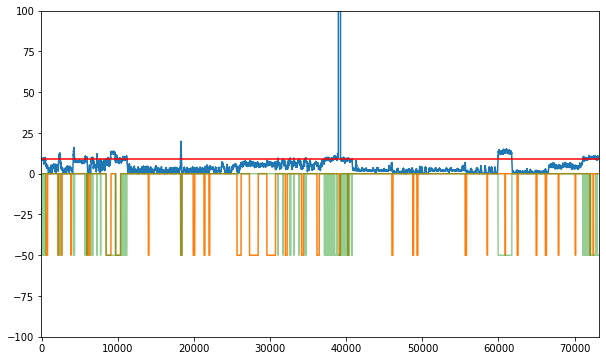

{'f1': 0.21991696573554706,
 'precision': 0.20092952853336626,
 'recall': 0.24287953979242288,
 'TP': 1859,
 'TN': 58168,
 'FP': 7393,
 'FN': 5795,
 'threshold': 8.847052158900055,
 'latency': 13.666514816502039}

In [61]:
latency = 1   
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=0.1, level=0.35, dynamic=False)
pot_th

In [36]:
latency = 1
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=0.1, level=0.999, dynamic=False)
print(pot_th)
latency = int(pot_th['latency'])
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=0.1, level=0.999, dynamic=False)
print(pot_th)

Running POT with q=0.1, level=0.999..
Initial threshold : 0.9279429547659319
Number of peaks : 40
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.09647131621991456
	σ = 0.038954718475722586
	L = 93.6730675342121
Extreme quantile (probability = 0.1): 0.7014057375120862


100%|██████████| 73215/73215 [00:00<00:00, 1848690.43it/s]


0
73215
{'f1': 0.7250567426931642, 'precision': 0.6872220914027357, 'recall': 0.7673112088224312, 'TP': 5873, 'TN': 62888, 'FP': 2673, 'FN': 1781, 'threshold': 0.7014057375120862, 'latency': 81.35246263257275}
Running POT with q=0.1, level=0.999..
Initial threshold : 0.9279429547659319
Number of peaks : 40
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.09647131621991456
	σ = 0.038954718475722586
	L = 93.6730675342121
Extreme quantile (probability = 0.1): 0.701526119178599


100%|██████████| 73135/73135 [00:00<00:00, 2219098.49it/s]

0
73135


{'f1': 0.758899301992259, 'precision': 0.7064054928443032, 'recall': 0.8198327661094424, 'TP': 6275, 'TN': 62873, 'FP': 2608, 'FN': 1379, 'threshold': 0.701526119178599, 'latency': 87.73638033484035}


### (Optional) epsilon, best F1 from Omnianomaly

In [59]:
import more_itertools as mit

def epsilon_eval(train_scores, test_scores, test_labels, reg_level=1):
    best_epsilon = find_epsilon(train_scores, reg_level)
    pred, p_latency = adjust_predicts(test_scores, test_labels, best_epsilon, calc_latency=True)
    if test_labels is not None:
        p_t = calc_point2point(pred, test_labels)
        return {
            "f1": p_t[0],
            "precision": p_t[1],
            "recall": p_t[2],
            "TP": p_t[3],
            "TN": p_t[4],
            "FP": p_t[5],
            "FN": p_t[6],
            "threshold": best_epsilon,
            "latency": p_latency,
            "reg_level": reg_level,
        }
    else:
        return {"threshold": best_epsilon, "reg_level": reg_level}


def find_epsilon(errors, reg_level=1):
    """
    Threshold method proposed by Hundman et. al. (https://arxiv.org/abs/1802.04431)
    Code from TelemAnom (https://github.com/khundman/telemanom)
    """
    e_s = errors
    best_epsilon = None
    max_score = -10000000
    mean_e_s = np.mean(e_s)
    sd_e_s = np.std(e_s)

    for z in np.arange(2.5, 12, 0.5):
        epsilon = mean_e_s + sd_e_s * z
        pruned_e_s = e_s[e_s < epsilon]

        i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
        buffer = np.arange(1, 50)
        i_anom = np.sort(
            np.concatenate(
                (
                    i_anom,
                    np.array([i + buffer for i in i_anom]).flatten(),
                    np.array([i - buffer for i in i_anom]).flatten(),
                )
            )
        )
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
        i_anom = np.sort(np.unique(i_anom))

        if len(i_anom) > 0:
            groups = [list(group) for group in mit.consecutive_groups(i_anom)]
            # E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

            mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
            sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) / sd_e_s
            if reg_level == 0:
                denom = 1
            elif reg_level == 1:
                denom = len(i_anom)
            elif reg_level == 2:
                denom = len(i_anom) ** 2

            score = (mean_perc_decrease + sd_perc_decrease) / denom

            if score >= max_score and len(i_anom) < (len(e_s) * 0.5):
                max_score = score
                best_epsilon = epsilon

    if best_epsilon is None:
        best_epsilon = np.max(e_s)
    return best_epsilon


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """

    print(f"Finding best f1-score by searching for threshold..")
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1.0, -1.0, -1.0)
    m_t = 0.0
    m_l = 0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target, latency = calc_seq(score, label, threshold)
        if target[0] > m[0]:
            m_t = threshold
            m = target
            m_l = latency
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)

    return {
        "f1": m[0],
        "precision": m[1],
        "recall": m[2],
        "TP": m[3],
        "TN": m[4],
        "FP": m[5],
        "FN": m[6],
        "threshold": m_t,
        "latency": m_l,
    }


def calc_seq(score, label, threshold):
    predict, latency = adjust_predicts(score, label, threshold, calc_latency=True)
    return calc_point2point(predict, label), latency

In [ ]:
best_valid_metrics = {}
t, th = bf_search(test_score, y_test[-len(test_score):],
                                      start=config.bf_search_min,
                                      end=config.bf_search_max,
                                      step_num=int(abs(config.bf_search_max - config.bf_search_min) /
                                                   config.bf_search_step_size),
                                      display_freq=50)
# get pot results
pot_result = pot_eval(train_score, test_score, y_test[-len(test_score):], level=config.level)

# output the results
best_valid_metrics.update({
    'best-f1': t[0],
    'precision': t[1],
    'recall': t[2],
    'TP': t[3],
    'TN': t[4],
    'FP': t[5],
    'FN': t[6],
    'latency': t[-1],
    'threshold': th
})
best_valid_metrics.update(pot_result)

In [60]:
dataset = 'MSL'
group = '1'
reg_level_dict = {"SMAP": 0, "MSL": 0, "SMD-1": 1, "SMD-2": 1, "SMD-3": 1}
key = "SMD-" + group if dataset == "SMD" else dataset
reg_level = reg_level_dict[key]

FD1wSAL_train = np.array(FD1wSAL_train)
FD1wSAL = np.array(FD1wSAL)
e_eval = epsilon_eval(FD1wSAL_train, FD1wSAL, y_test[:-(len(y_test)-len(FD1wSAL))], reg_level=reg_level)
print("e_eval:", e_eval)

bf_eval = bf_search(FD1wSAL, y_test[:-(len(y_test)-len(FD1wSAL))], start=0, end=200, step_num=100, verbose=False)
print("bf_eval;", bf_eval)


e_eval: {'f1': 0.6030345550057847, 'precision': 0.49670162339588836, 'recall': 0.7673112088224312, 'TP': 5873, 'TN': 59611, 'FP': 5951, 'FN': 1781, 'threshold': 1.1618808547432227, 'latency': 42.999747060311414, 'reg_level': 0}
Finding best f1-score by searching for threshold..
bf_eval; {'f1': 0.6565492040918467, 'precision': 0.9156147711182451, 'recall': 0.5117585569483165, 'TP': 3917, 'TN': 65201, 'FP': 361, 'FN': 3737, 'threshold': 2.0, 'latency': 326.28105312781247}


In [1]:
pot_th = pot_eval(FIN_DIST_train, FIN_DIST, label=y_test[:-(len(y_test)-len(FIN_DIST))], q=0.05, level=0.99, dynamic=True)
pot_th

NameError: name 'pot_eval' is not defined

Running POT with q=0.01, level=0.99..
Initial threshold : 132.33325
Number of peaks : 582
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4.6696057
	L = 1478.905441884447
Extreme quantile (probability = 0.01): 132.33188817810918


100%|██████████| 73629/73629 [00:00<00:00, 2149017.49it/s]

0
73629


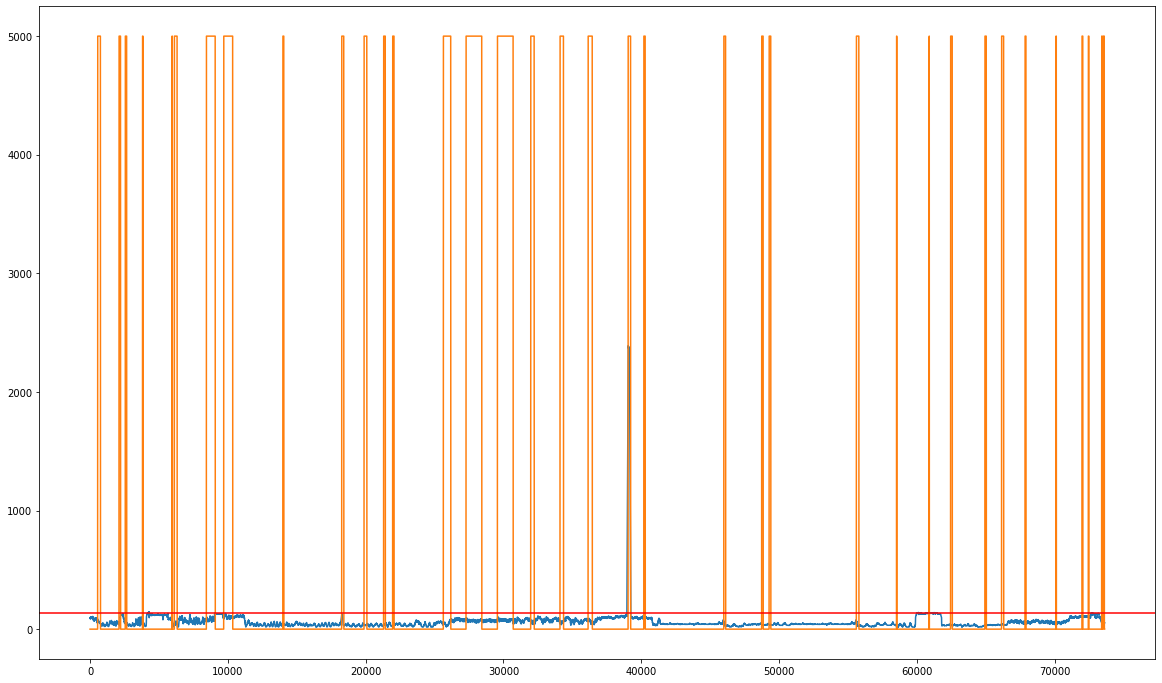

{'f1': 0.28107621036246055,
 'precision': 0.5425414344657774,
 'recall': 0.18967293305476057,
 'TP': 1473,
 'TN': 64621,
 'FP': 1242,
 'FN': 6293,
 'threshold': 132.33188817810924,
 'latency': 243.99186693776872}

In [30]:
pot_th = pot_eval(DIST_SAL_train, DIST_SAL, label=y_test[:len(y_test)-100], q=1e-2, level=0.99, dynamic=False)
pot_th